# 1.1 - Explore forest-masked GBIF data

In [1]:
from affine import Affine
import math
from typing import Generator
import os

from dotenv import find_dotenv, load_dotenv
import geopandas as gpd
import numpy as np
import pandas as pd
import rasterio
import seaborn as sns
import pygeos
from shapely.geometry import Point
from geopandas import GeoSeries
from tqdm.notebook import tqdm

from src.conf.parse_params import config as cfg
from src.utils.df_utils import read_df, read_gdf

load_dotenv(find_dotenv())
os.chdir(os.environ["PROJECT_ROOT"])

%load_ext autoreload
%autoreload 2

## Species composition

After masking the GBIF data to contain only observations in forested areas, let's do a quick sanity check of the species abundances by looking at the top ten.

In [47]:
gbif = read_gdf(cfg["gbif"]["masked"]).astype({"species": "string[pyarrow]"})

In [48]:
unique_species_count = gbif.species.nunique()
print(f"Unique species: {unique_species_count}")
print(f"\n{gbif.species.value_counts()[:10]}")

Unique species: 9239

species
Fagus sylvatica        147092
Quercus robur          104352
Sorbus aucuparia        96903
Urtica dioica           93114
Picea abies             79446
Fraxinus excelsior      73032
Acer pseudoplatanus     71263
Filipendula ulmaria     70993
Juncus effusus          68834
Corylus avellana        68024
Name: count, dtype: int64[pyarrow]


It looks like _Fagus sylvatica_ (European beech) is the most abundant species, followed by _Quercus robur_ (pedunculate oak), and there are 9,329 unique species occurrences.

Additionally, let's look at the number of species with only 5 observations or fewer.

In [49]:
counts = gbif.species.value_counts()
filtered_counts = counts[counts <= 5]
species_count = len(filtered_counts)
average_for_top_100 = counts[:100].mean()
print(f"Number of species with <= 5 observations: {species_count}")
print(f"Percentage of total: {(species_count / unique_species_count) * 100:.2f}%")
print(f"Average # of observations for top 100 species: {average_for_top_100:.0f}")

Number of species with <= 5 observations: 3953
Percentage of total: 42.79%
Average # of observations for top 100 species: 47691


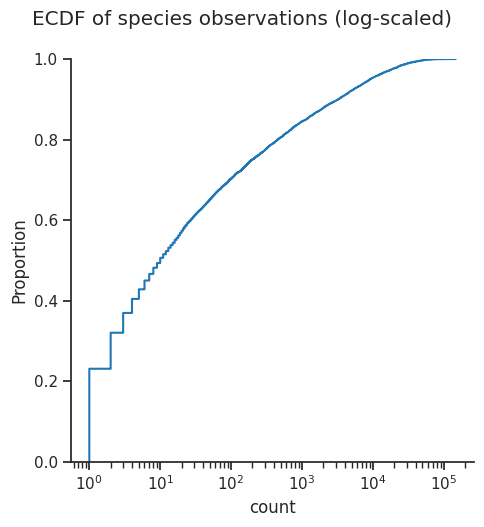

In [59]:
with sns.plotting_context("notebook"):
    sns.set_style("ticks")
    g = sns.displot(counts, kind="ecdf", log_scale=True)
    g.figure.suptitle("ECDF of species observations (log-scaled)", y=1.05)
    g.despine();

Nearly half of the observed species have extremely low abundance compared to the top 100 species documented in the masked GBIF data. With this in mind let's look into the complexity of the task at hand.

## Problem complexity

Now that the GBIF data has been masked to only contain observations in forested areas, let's assess the general complexity of the problem to help select an approach. We can start by looking at the number of species in combination with the raster sizes. These are critical figures as different approaches may require us to iterate over each species and/or every grid cell of the target rasters to generate the desired statistics.

We start by loading in the GBIF data in its non-GeoDataFrame format in which we've also replaced species name with a species id (see `dvc repro save_species_ids_points`).

In [54]:
gbif = read_df(cfg["gbif"]["points"])
unique_species = gbif.species_id.nunique()
print("Unique species:", unique_species)

Unique species: 9239


Next we will load each Sentinel-2 target raster and do some simple math to calculate the total number of operations for two approaches.

In [55]:
with rasterio.open(cfg["s2_10m"]["src"]) as src:
    shape_10m = (src.height, src.width)

with rasterio.open(cfg["s2_20m"]["src"]) as src:
    shape_20m = (src.height, src.width)

print(f"S2 10m shape: {shape_10m}")
print(f"S2 10m cell count: {math.prod(shape_10m):,}")
print(f"\nS2 20m shape: {shape_20m}")
print(f"S2 20m cell count: {math.prod(shape_20m):,}")

S2 10m shape: (86500, 64100)
S2 10m cell count: 5,544,650,000

S2 20m shape: (43300, 32100)
S2 20m cell count: 1,389,930,000


So, if we can gather statistics for **all species** on a **single pass** of each raster for each desired radius, and our approach is cell-based, we are looking at:

$(86500 * 64100 + 43300 * 32100) * 5 = 1.249e+10$

or ~12.5 billion operations.

If we choose an approach that iterates over **each grid for each species**, then we can multiply that figure by 9,239, which leads to:

~115.4 trillion operations.

One way this could be sped up is by filtering species from GBIF that could be considered outliers.

In [56]:
counts = gbif["species_id"].value_counts()

quantile = 0.05
threshold = counts.quantile(quantile)

gbif_filt = gbif[gbif["species_id"].map(counts) > threshold]

print(f"{quantile * 100:g}th percentile # of observations:", int(threshold))
print("Number of species:", gbif_filt.species_id.nunique())

5th percentile # of observations: 1
Number of species: 7109


This removes almost a quarter of the GBIF species where the observation count was only 1. As we saw above, the dataset is pretty skewed in this way, however, and increasing the quantile threshold to 0.1 or 0.2 doesn't remove any more species.

7,109 species is still a lot, and so we should prefer an approach that doesn't rely on iterating over each species for each grid cell to reduce adding another order of magnitude or four to the operational complexity. 

For our purposes, and given said operational complexity, we will focus only on the top 100 most observed species.

In [58]:
top_species = counts.nlargest(100).index
filtered_points = gbif[gbif.species_id.isin(top_species)]
pct_of_total = (filtered_points.shape[0] / gbif.shape[0]) * 100
print(f"Number of filtered observations:", filtered_points.shape[0])
print(f"Filtered points percent of total points: {pct_of_total:.2f}%")

Number of filtered observations: 4769067
Filtered points percent of total points: 31.48%


## Tree-based querying

### Querying by grid cell centroid

One method to query species occurrences within a given radius at each grid cell center for each species is to calculate the centroid of each grid cell and then iterate over all centroids, querying for all species occurrences in a given radius for each one.

To do this we can leverage a K-d tree or [R-tree](https://en.wikipedia.org/wiki/R-tree) for (relatively) quick spatial indexing. R-trees are perhaps easier to work with, but may have performance costs compared to K-d trees (though possible not signficant). This can be done using the built-in `GeoDataFrame.sindex` method from `geopandas`.

In [ ]:
raster_src = cfg["s2_20m"]["src"]
RADIUS = 1000
points = (
    read_df(cfg["gbif"]["points"])
    .assign(geometry=lambda df_: gpd.points_from_xy(df_.x, df_.y))
    .drop(columns=["x", "y"])
    .pipe(lambda df_: gpd.GeoDataFrame(df_))
)

counts = points.species_id.value_counts()
top_species = counts.nlargest(100).index
filtered_points = points[points.species_id.isin(top_species)]


def get_centroids(shape: tuple, transform: Affine) -> Generator[Point, None, None]:
    """Get grid cell centroids from a raster with a given width, height, and transform.
    Centroids are returned in the flattened shape ((height * width), 2)
    """
    for row in range(shape[0]):
        for col in range(shape[1]):
            x_coord, y_coord = transform * (  # pyright: ignore[reportGeneralTypeIssues]
                col + 0.5,
                row + 0.5,
            )
            yield Point(x_coord, y_coord)


def weighted_count(
    matches: gpd.GeoDataFrame | gpd.GeoSeries, point: Point, radius: int | float
) -> float:
    """Compute a weighted count of the number of points within a given distance of a point."""
    weights = (radius - matches.distance(point)) / radius
    return weights.sum()


with rasterio.open(raster_src) as src:
    target_shape = (src.meta["height"], src.meta["width"])
    target_transform = src.transform
    resolution = int(abs(src.res[0]))

query_set = f"{resolution} res, {RADIUS} radius"
print("Computing stats for %s", query_set)

sindex = filtered_points.sindex
centroids = get_centroids(target_shape, target_transform)
total = target_shape[0] * target_shape[1]

data = []
for i, centroid in enumerate(tqdm(centroids, total=total)):
    buffer = centroid.buffer(RADIUS)
    precise_matches_idx = sindex.query(buffer, predicate="intersects")
    if len(precise_matches_idx) > 0:
        centroid = buffer.centroid
        row, col = src.index(centroid.x, centroid.y)
        precise_matches = filtered_points.iloc[precise_matches_idx]
        for sp_id, obs in precise_matches.groupby("species_id"):
            count = len(obs)
            wt_count = weighted_count(
                obs,  # pyright: ignore[reportGeneralTypeIssues]
                centroid,
                RADIUS,
            )
            data.append([row, col, sp_id, count, wt_count])

This approach iterates over each grid cell and returns each grid cell that contains observations in its query, along with their IDs and statistics.

The benefits of this approach are that it is a) fairly memory-efficient, which is important because if we were to divide this up for multiprocessing we would need to read the raster and generate the spatial index in each subprocess, and b) it returns only the information we need (grid cell coordinates that contain species in their queries, along the species IDs and their respective statistics).

However, if we let this run a while we can see that, although this approach works on small grids, it will take many hours (~300) for a single 20m resolution grid without multiprocessing. If we divide it up across 48 cores, for example, we could reduce the computation time to ~6.25 hours, though it would likely be higher as we may not have enough memory to support that many processes, and multiprocessing often runs each subprocess slightly less efficiently than a single process due to the complexity of these data.

That said, many grid cells contain no observations, so perhaps there is another way to minimize the number of grid cells we need to perform queries on.

### Querying by species point

Another potential method for getting species-based statistics is to instead iterate over species points first to identify the relevant grid cells, and then query the species points from only the grid cells that we suspect contain species in the query radius.

Here's how we might do this.

**First pass**

1. Iterate over species points
2. For each point, find its corresponding grid cell in the raster, and then find all raster cells within the query radius (+1 grid cell size to make sure we don’t cut off grid cells?).
3. Store the row, col of all grid cells

**Second pass**

1. Build a tree from species points
2. Get centroids for all raster cells identified and only iterate over those using the previous method.

If this still takes too long, we can modify the second pass:

**Second pass (modified; if necessary)**
1. For each point, calculate the centroids of each of the cells in the radius neighborhood
2. Build a spatial index for the cells in the neighborhood
3. Query the centroid tree from the point
3. Store all centroids that intersect as well as their distances.
4. The resulting data structure would look like:
    1. species id, point
        - [intersecting grid cell 0, distance]
        - ...
5. The data would then need to be grouped by grid cell:
    1. grid cell
        - species id
            - array of distance(s)
        - ...
        ...
6. From there we could aggregate species_ids within grid cells to calculate counts and average distance (to be used as a weight for counts)

### First pass

In [6]:
raster_src = cfg["s2_20m"]["src"]
RADIUS = 1000
RES = 20
points = (
    read_df(cfg["gbif"]["points"])
    .assign(geometry=lambda df_: gpd.points_from_xy(df_.x, df_.y))
    .drop(columns=["x", "y"])
    .pipe(lambda df_: gpd.GeoDataFrame(df_))
)

counts = points.species_id.value_counts()
top_species = counts.nlargest(100).index
filtered_points = points[points.species_id.isin(top_species)].reset_index(drop=True)

First, get all rows and columns of the target raster that contain species observations.

In [7]:
cell_radius = RADIUS // RES + 1

src = rasterio.open(raster_src)

# Get rows and cols for all points
rows, cols = src.index(filtered_points.geometry.x, filtered_points.geometry.y)

Drop duplicate pairs of `rows` and `cols` as some cells contain multiple observations.

In [8]:
# Create a DataFrame from rows and cols and drop duplicates
df = pd.DataFrame({
    'row': rows,
    'col': cols
}).astype(np.int32).drop_duplicates(ignore_index=True)

print(f"Dropped {len(rows) - df.shape[0]} duplicates.")

Dropped 4213049 duplicates.


Next, create a radial kernel with a radius of the query radius + 1 (this is why we added one when assigning `cell_radius` above) to ensure that no potential grid cells are missed.

In [6]:
# Generate a radial kernel
y, x = np.ogrid[-RES:RES+1, -RES:RES+1]
mask = x**2 + y**2 <= RES**2

# Get the row and column offsets from the kernel
row_offsets, col_offsets = np.where(mask)

# Adjust the offsets so that the center of the kernel is at (0, 0)
row_offsets -= RES
col_offsets -= RES

Finally, get all grid cell indices that fall within our desired `cell_radius`, and don't forget to reset values of rows and columns that would fall outside the raster.

In [7]:
# Calculate the rows and columns of the kernel for the unique points
print("Calculating for rows...")
kernel_rows = np.repeat(df["row"].values, len(row_offsets)) + np.tile(
    row_offsets, len(df)
)
print("Calculating for cols...")
kernel_cols = np.repeat(df["col"].values, len(col_offsets)) + np.tile(
    col_offsets, len(df)
)

print("Creating dataframe...")
# Create a new DataFrame from the rows and columns of the kernel
df_kernel = (
    pd.DataFrame({"row": kernel_rows, "col": kernel_cols})
    .astype(np.int32)
    .drop_duplicates(ignore_index=True)
)
if df_kernel.row.max() >= src.height:
    df_kernel = df_kernel.assign(
        row=lambda df_: np.where(
            df_["row"] > src.height - 1, src.height - 1, df_["row"]
        )
    )
if df_kernel.col.max() >= src.width:
    df_kernel = df_kernel.assign(
        col=lambda df_: np.where(df_["col"] > src.width - 1, src.width - 1, df_["col"]),
    )
if df_kernel.row.min() < 0:
    df_kernel = df_kernel.assign(
        row=lambda df_: np.where(df_["row"] < 0, 0, df_["row"]),
    )
if df_kernel.col.min() < 0:
    df_kernel = df_kernel.assign(
        col=lambda df_: np.where(df_["col"] < 0, 0, df_["col"]),
    )

df_kernel = df_kernel.drop_duplicates(ignore_index=True)

del df, rows, cols

Calculating for rows...
Calculating for cols...
Creating dataframe...


Close the raster and inspect the savings in terms of computational complexity.

In [8]:
src.close()

pct_of_raster = df_kernel.shape[0] / (src.height * src.width)
print(
    f"Percent of original raster: {pct_of_raster * 100:.2f}%, "
    f"a savings of {(1 - pct_of_raster) * 100:.2f}%."
)

Percent of original raster: 18.01%, a savings of 81.99%.


### Second pass

Now we can focus only on the grid cells that are near species points by using the initial R-tree approach.

First we need to redefine out `get_centroids` function to take a list of coordinates instead of the shape of a raster.

In [7]:
from typing import Iterable


def get_row_cols(df: pd.DataFrame) -> Generator[tuple, None, None]:
    for item in df[["row", "col"]].values:
        yield item[0], item[1]


def get_centroids(
    row_cols: Iterable[tuple], transform: Affine, xy: bool = False
) -> Generator[tuple, None, None] | Generator[Point, None, None]:
    """Get grid cell centroids from a raster with a given width, height, and transform.
    Centroids are returned in the flattened shape ((height * width), 2)
    """
    for row, col in row_cols:
        x_coord, y_coord = transform * (  # pyright: ignore[reportGeneralTypeIssues]
            col + 0.5,
            row + 0.5,
        )
        if xy:
            yield x_coord, y_coord
        else:
            yield Point(x_coord, y_coord)


def weighted_count(
    matches: gpd.GeoDataFrame | gpd.GeoSeries, point: Point, radius: int | float
) -> float:
    """Compute a weighted count of the number of points within a given distance of a point."""
    weights = (radius - matches.distance(point)) / radius
    return weights.sum()

In [ ]:
with rasterio.open(raster_src) as src:
    target_shape = (src.meta["height"], src.meta["width"])
    target_transform = src.transform
    resolution = int(abs(src.res[0]))

query_set = f"{resolution} res, {RADIUS} radius"
print("Computing stats for %s", query_set)

sindex = filtered_points.sindex

centroids = get_centroids(get_row_cols(df_kernel), target_transform)
total = df_kernel.shape[0]

data = []
for i, centroid in enumerate(tqdm(centroids, total=total)):
    buffer = centroid.buffer(RADIUS)
    precise_matches_idx = sindex.query(buffer, predicate="intersects")
    if len(precise_matches_idx) > 0:
        centroid = buffer.centroid
        row, col = src.index(centroid.x, centroid.y)
        precise_matches = filtered_points.iloc[precise_matches_idx]
        for sp_id, obs in precise_matches.groupby("species_id"):
            count = len(obs)
            wt_count = weighted_count(
                obs,  # pyright: ignore[reportGeneralTypeIssues]
                centroid,
                RADIUS,
            )
            data.append([row, col, sp_id, count, wt_count])

Unfortunately, after letting it run for a few minutes, we can see that even querying the filtered grid cells with the filtered points will still take very long (~4000 hours) on a single processor.

## Modified approach

**Let's investigate a modified approach, in which, instead of querying each grid cell, we build the centroid tree as we sample the relevant grid cells for each point and perform a reverse query to get the grid cell centroids within the radius of the point as well as their distances. One benefit of this approach is that it should be easily multiprocessed.**

Two other options are:
- Build a spatial index of the relevant grid cell centroids to see which other grid centroids are in the neighborhood (probably memory-constrained to build that many centroids).
- Pass a convolutional kernel over only the grid cells in `df_kernel`. This would require that the convolution method be able to accept sparse matrices, or that we iterate over the relevant cells manually.

First let's create the kernel function.

In [2]:
def pixel_to_coord(row, col, transform):
    """Returns global coordinates to pixel center using base-0 raster index"""
    x = transform.c + transform.a * col + transform.b * row
    y = transform.f + transform.d * col + transform.e * row
    return x, y


def get_kernel_centroids(origin: np.ndarray, radius, transform) -> tuple:
    y, x = np.ogrid[-radius : radius + 1, -radius : radius + 1]
    mask = x**2 + y**2 <= radius**2

    indices = np.argwhere(mask) - radius
    neighborhood_idx = indices + np.array(origin)
    centroids = neighborhood_idx + 0.5
    transformed_centroids = np.zeros(centroids.shape)
    for i, centroid in enumerate(centroids):
        transformed_centroids[i, 0], transformed_centroids[i, 1] = pixel_to_coord(
            centroid[0], centroid[1], transform
        )
    return neighborhood_idx, transformed_centroids

We can then write a function that takes the neighborhood indices, the centroids, the current GBIF observation, and the query radius to create a K-d tree from the neighborhood centroids (in the raster coordinate system) which we can then query from each observation point. From that we will get each grid cell centroid that is within the query radius of the GBIF point, as well as their distances.

Later we can aggregate this data to get observation counts per species per grid cell, and we can weight those counts by the average distances.

In [3]:
from scipy.spatial import KDTree
from scipy.spatial.distance import euclidean


def get_kernel_stats(hood_idx, kernel_centroids, origin, radius) -> list[tuple]:
    # print(f"hood_idx shape: {hood_idx.shape}, kernel_centroids shape: {kernel_centroids.shape}")
    kernel_tree = KDTree(kernel_centroids)
    nearest_indices = kernel_tree.query_ball_point(origin, radius)
    # print(f"nearest_indices shape: {len(nearest_indices)}")
    distances = np.array([euclidean(origin, kernel_centroids[i]) for i in nearest_indices])
    # print(f"distances shape: {len(distances)}")
    return [(hood_idx[j], distances[i]) for i, j in enumerate(nearest_indices)]

Now read the data and select the top 100 species.

In [4]:
raster_src = cfg["s2_20m"]["src"]
src = rasterio.open(raster_src)
RADIUS = 1000
RES = 20
cell_radius = RADIUS // RES

points = read_df(cfg["gbif"]["points"])

counts = points.species_id.value_counts()
top_species = counts.nlargest(100).index
filtered_points = points[points.species_id.isin(top_species)].reset_index(drop=True)

Split out the observation coordinates and their corresponding IDs.

In [5]:
xy = np.c_[filtered_points.x, filtered_points.y]
sp_idx = filtered_points.species_id

#### Pure multiprocessing

In [11]:
def chunks(lst, n):
    """Yield successive n-sized chunks from lst."""
    for i in range(0, len(lst), n):
        yield lst[i : i + n]



N_CHUNKS = 1500
N_PROCS = 48

# Split the data into chunks for multiprocessing
chunk_size = len(sp_idx) // N_CHUNKS + (len(sp_idx) % N_CHUNKS > 0)
point_chunks = list(chunks(list(zip(sp_idx, xy)), chunk_size))

print("Chunk size:", chunk_size)

Chunk size: 3180


In [ ]:
import gc
import pandas as pd
from multiprocessing import Pool, cpu_count
import rasterio

N_PROCS = 40


def chunks(lst, n):
    """Yield successive n-sized chunks from lst."""
    for i in range(0, len(lst), n):
        yield lst[i : i + n]


def process_chunk(args):
    chunk, raster_src = args
    data = []
    with rasterio.open(raster_src) as src:
        data = (
            (sp_id, f"{grid_cell[0]} {grid_cell[1]}", distance)
            for sp_id, point in chunk
            for grid_cell, distance in get_kernel_stats(
                *get_kernel_centroids(
                    np.array(src.index(point[0], point[1])), cell_radius, src.transform
                ),
                origin=point,
                radius=RADIUS,
            )
        )
    src.close()
    df = pd.DataFrame(data, columns=["species_id", "grid_cell", "distance"]).astype(
        {
            "species_id": "category",
            "grid_cell": "string[pyarrow]",
            "distance": np.float32,
        }
    )

    del data, df, src
    gc.collect()

    # When processing the full set, we will probably want to write each df to disk to
    # conserve memory, but for now we'll return it
    # df.to_parquet("path/to/file.parquet")
    print("Chunk processed.")
    return None


N_CHUNKS = 1000
N_PROCS = 48

# Split the data into chunks for multiprocessing
chunk_size = len(sp_idx) // N_CHUNKS + (len(sp_idx) % N_CHUNKS > 0)
point_chunks = list(chunks(list(zip(sp_idx, xy)), chunk_size))

with Pool(N_PROCS) as p:
    results = p.map(process_chunk, [(chunk, raster_src) for chunk in point_chunks])

# Combine all of the dataframes from each chunk. Then we can group them by grid cell
# and species ID, and from that we can determine the species abundances (counts) and
# weight them by their average distances.
result_df = pd.concat(results)
final_df = (
    result_df.groupby(["grid_cell", "species_id"], observed=False)
    .agg(count=("distance", "count"), mean_distance=("distance", "mean"))
    .assign(wt_count=lambda df_: df_["count"] * (1 - df_["mean_distance"] / RADIUS))
    .drop(columns="mean_distance")
    .astype({"wt_count": np.float16})
)